In [1]:
from src.hpe.mp.performance import EstimationCollector

collector = EstimationCollector()
df_mp = collector.collect(name="estimations")

2025-10-08 09:44:16.043244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759909456.059206  798434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759909456.063814  798434 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 09:44:16.080459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded labels


libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
MESA: error: ZINK: failed to choose pdev
libEGL warning: egl: failed to create dri2 screen
I0000 00:00:1759909495.392035  798434 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1759909495.447070  799203 gl_context.cc:357] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA TITAN RTX)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1759909495.879013  799133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1759909496.906817  799134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1759909496.934443  799154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single s

In [52]:
fp_pred = df_mp.iloc[9]['HEAD']

In [57]:
from src.hpe.common.helpers import eucl_distance


print(f"limit: {fp_pred._head_bone_link / 2}")
print(f"distance: {eucl_distance(fp_pred._true_landmark.as_array(), fp_pred._predicted_landmark.as_array())}")
print(fp_pred.prediction_result(0))

limit: 0.004269529704194191
distance: 0.004739110182184911
FP


In [2]:
from src.hpe.yolo.performance import EstimationCollector as YoloEstimationCollector

collector = YoloEstimationCollector()
df_yolo = collector.collect(name="estimations")


0: 448x640 1 person, 36.6ms
Speed: 13.0ms preprocess, 36.6ms inference, 289.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 41.1ms
Speed: 3.6ms preprocess, 41.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 15.5ms
Speed: 2.6ms preprocess, 15.5ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 (no detections), 16.2ms
Speed: 2.9ms preprocess, 16.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 15.3ms
Speed: 3.1ms preprocess, 15.3ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 15.5ms
Speed: 2.7ms preprocess, 15.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 16.2ms
Speed: 2.6ms preprocess, 16.2ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 15.4ms
Speed: 2.8ms preprocess, 15.4ms inference, 2.8ms postprocess per image at shap

In [ ]:
from src.hpe.mp.performance import read_estimations as read_mp_estimations
from src.hpe.yolo.performance import read_estimations as read_yolo_estimations

df_mp = read_mp_estimations()
df_yolo = read_yolo_estimations()

In [50]:
from src.hpe.common.performance import HpeEstimation

prediction_results = df_mp.map(lambda x: x.prediction_result(0))

In [12]:
prediction_confidences = df_mp.map(lambda x: x.predicted_landmark.visibility)

In [51]:
from pandas import Series

counts = prediction_results.apply(Series.value_counts).fillna(0)
totals = counts.apply(sum, axis=1)

In [ ]:
totals["FN"]

In [35]:
from pandas import DataFrame

def safe_index(data: DataFrame, index: str, fallback = 0) -> int:
    return data[index] if index in data.keys() else fallback

def precision(totals: DataFrame) -> float:
    tp = safe_index(totals, "TP")
    fp = safe_index(totals, "FP")

    if tp + fp == 0:
        return 0.0
    return tp  / (tp + fp)

def recall(totals: DataFrame) -> float:
    tp = safe_index(totals, "TP")
    fn = safe_index(totals, "FN")

    if tp + fn == 0:
        return 0
    return tp  / (tp + fn)

In [36]:
print(f"Precision: {precision(totals)}")
print(f"Recall: {recall(totals)}")

Precision: 0.0
Recall: 0.0


In [65]:
from typing import Tuple, List
from numpy import arange
from src.hpe.common.performance import HpeEstimation
from pandas import Series

def calculate_precision_and_recall(estimations: DataFrame) -> Tuple[List[float], List[float]]:
    conf_increment = 0.001
    confidences = arange(0, 1, conf_increment)
    average_precision = 0
    recall_x = [0] * len(confidences)
    precision_y = [0] * len(confidences)
    previous_recall = 0

    for idx, conf in enumerate(confidences):
        
        def prediction_result(estimation: HpeEstimation) -> str:
            return estimation.prediction_result(conf)

        prediction_results = estimations.map(prediction_result)
        counts = prediction_results.apply(Series.value_counts).fillna(0)
        totals = counts.apply(sum, axis=1)
        current_recall = recall(totals)
        current_precision = precision(totals) 
        
        recall_x[idx] = current_recall
        precision_y[idx] = current_precision
        average_precision = average_precision + abs(current_recall - previous_recall) * current_precision
        
        previous_recall = current_recall

    print(f"Average precision is: {average_precision}")
    
    return precision_y, recall_x


In [66]:
prec, rec = calculate_precision_and_recall(df_mp)

Average precision is: 0.6609032246709332


In [67]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precision_y: List[float], recall_x: List[float]):
    plt.plot(recall_x, precision_y)
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    

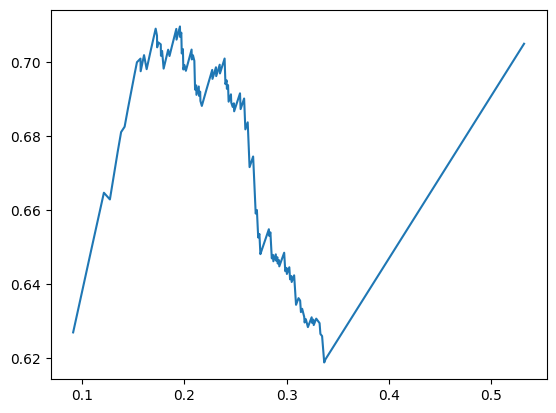

In [68]:
plot_precision_recall_curve(prec, rec)

In [ ]:
from src.hpe.yolo.performance import read_distances as read_yolo_distances
from src.hpe.mp.performance import read_distances as read_mp_distances
from src.hpe.common.plot import plot_distances_boxplot

mp_dist = read_mp_distances(dataset_name="distances")
mp_bgr_dist = read_mp_distances(dataset_name="distances_bgr")

yolo_dist = read_yolo_distances(dataset_name="distances")
yolo_bgr_dist = read_yolo_distances(dataset_name="distances_bgr")

In [ ]:
plot_distances_boxplot(
    None,
    ("MediaPipe", mp_dist),
    ("MediaPipe on bgr", mp_bgr_dist),
    ("Yolov11", yolo_dist),
    ("Yolov11 on bgr", yolo_bgr_dist))

In [ ]:
plot_distances_boxplot(
    (0, 10),
    ("MediaPipe", mp_dist),
    ("MediaPipe on bgr", mp_bgr_dist),
    ("Yolov11", yolo_dist),
    ("Yolov11 on bgr", yolo_bgr_dist))

In [ ]:
from src.hpe_dnn.kfold import HpeDnnFoldCrossValidation
from src.sota.kfold import SOTAFoldCrossValidation
from src.common.plot import box_plot_accuracies

box_plot_accuracies(
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-mp-kf"),
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-mp-unbalanced-kf"),
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-mp-dr0.3-kf"),
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-yolo-kf"),
    # HpeDnnFoldCrossValidation.evaluation_instance("arch2-kf"), 
    # HpeDnnFoldCrossValidation.evaluation_instance("arch3-kf"), 
    # HpeDnnFoldCrossValidation.evaluation_instance("arch4-kf"), 
    # HpeDnnFoldCrossValidation.evaluation_instance("arch5-kf"),
    SOTAFoldCrossValidation.evaluation_instance("yolo11n-kf", "yolov11n-cls"))